# About

Create a function that can be used in the 2nd stage regression to perform a time series cross validation. 
- Using an expanding window cross validation
- Use sklearn API for the xgb function

The 2nd stage regression predicts the medical outcomes using the predicted PM2.5 (and separately with the actual pm2.5), as well as the same fixed effects from the first stage regression. 

In [2]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [3]:
# keep this as false unless you want to save out the fitted model objects and results 
save_results = False

Set lag/lead times

Combinations of Instruments and Fixed Effects here:
https://docs.google.com/spreadsheets/d/1_MMYeQuxiov2OLE5AX0CE9R1T1mBrk7vpozy2fGjNBg/edit#gid=0 

Instruments:

- `Izmy_v3_normed_D_and_TPY`
- `Izmy_v4_nodist_normed_TPY`
- `Izmy_v5_all_normed_but_wspd_ratio`


We will use lead and lag of 9 months and 3 months respectively.

For fixed effects, we choose from a set of 4 possible combinations outlined here:

- https://docs.google.com/spreadsheets/d/1_MMYeQuxiov2OLE5AX0CE9R1T1mBrk7vpozy2fGjNBg/edit#gid=0

In [4]:
# set instrumental variable version
##  Predictor options:
# - `Izmy_v3_normed_D_and_TPY`
# - `Izmy_v4_nodist_normed_TPY`
# - `Izmy_v5_all_normed_but_wspd_ratio`

predictor = 'Izmy_v3_normed_D_and_TPY'

# set FE to one of 4 sets (int)
FE_set_num = 2

# specify medical target
medical_target = 'y_hematopoietic'

# sets unique notebooks index (string)
notebook_index = "01"

# name of the counterfactual csv file for Tableau maps
counterfactual_csv_name = 'XGBoost_Stage2_Dataframe_anand_test_11-29-22'

In [5]:
lead_time = '9'
lag_time = '3'
lag_style = 'fwd'

# define lead time for IV: 'last_month', 'r6', 'r9', 'r12'
IV_lead = "r" + str(lead_time)
HO_lag = lag_style + str(lag_time)

if IV_lead:
    IV_lead_input = "_" + IV_lead 
else:
    # don't add underscore if empty string
    IV_lead_input = IV_lead

# define lag time for Health Outcome: '', 'fwd3', 'cent3', 'fwd6', 'cent6', 'fwd12', 'cent12'
if HO_lag:
    HO_lag_input = "_" + HO_lag 
else:
    # don't add underscore if empty string
    HO_lag_input = HO_lag

# IV options: 1 month, 6 months, 9 months, 12 months
IV_window_col = [f'pm25{IV_lead_input}']

# health outcome options (fwd or cent): 1 month, 3 months, 6 months, 12 months
health_outcome_window_col = [f'y_injuries{HO_lag_input}']

filter_cols = IV_window_col + health_outcome_window_col # columns to filter out at the beginning and end of df, before modeling

target_name_s1 = f'pm25{IV_lead_input}'
predictor_name_s1 = f'{predictor}{IV_lead_input}'

print(f"Stage 1\nTarget Name (target_name_s1) = {target_name_s1}\nPredictor Name (predictor_name_s1) = {predictor_name_s1}")

print(f"\nStage 2\nHealth Outcome Lag Input (HO_lag_input) = {HO_lag_input}")

Stage 1
Target Name (target_name_s1) = pm25_r9
Predictor Name (predictor_name_s1) = Izmy_v3_normed_D_and_TPY_r9

Stage 2
Health Outcome Lag Input (HO_lag_input) = _fwd3


# Set Path

Add a new elif section for your path if you want

In [6]:
# local or gdrive
path_source = 'local_anand'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

elif path_source == 'local_anand':
  data_path = 'G:\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data'
  fitted_models_path = 'G:\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\W210_Capstone\\fitted_models\\2022-11-19\\XGB'

  out_dir1 = 'G:\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\W210_Capstone\\fitted_models\\2022-11-19\\XGB'

elif path_source == 'local_cornelia':
  in_dir_sc = 'C:/Users/cilin/Research/CA_hospitals_capstone/data/'
  in_dir_h = 'C:/Users/cilin/Research/CA_hospitals_capstone/output/'
  # folder containing stage 1 outputs
  out_dir1 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s1/'
  # folder containing stage 2 outputs
  out_dir2 = 'C:/Users/cilin/Research/CA_hospitals_capstone/models_s2/'
  # folder containing csvs documenting which fixed effects are in which csv files
  out_dir3 = 'C:/Users/cilin/Research/CA_hospitals_capstone/fixed_effects/'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

In [7]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_joined_11-22-top15_4tpy_ds_wind_ratios.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]
df4 = pd.read_csv(os.path.join(data_path, 'medical/resp_cardio.csv')).iloc[:,1:]
df5 = pd.read_csv(os.path.join(data_path, 'medical/injuries_accidents.csv')).iloc[:,1:]

# Data Clean

In [8]:
def roll_selected_cols(df, cols_to_roll:list = ['Izmy_v1_unnormed'\
    ,'Izmy_v2_nodist_unnormed' \
    ,'Izmy_v3_normed_D_and_TPY' \
    ,'Izmy_v4_nodist_normed_TPY' \
    ,'Izmy_v5_all_normed'
    ,'Izmy_v6_unnormed_no_wspd'
    ,'Izmy_v7_all_normed_no_wspd'
    ,'Izmy_v8_normed_D_and_TPY_no_wspd'
    ,'new_alignment_90_high'
    ,'avg_temp']
    ,rolling_periods:list = [1, 6, 9, 12]):

    """Generates rolling averages for the input variables over the input time periods.
    Inputs: df (pd dataframe): contains the data on a y-m level
            cols_to_roll (list): list of columns to generate rolling avgs--must be in df
            rolling_periods (list): list of time windows (in months) to roll over
            
    Outputs: df: Pandas dataframe containing the new columns
             all_cols: list of list containing the new columns, separated by input type"""
    
    df_int = df.copy().sort_values(['school_zip', 'year_month']).reset_index(drop=True)
    
    all_cols_int = []

    # Roll each variable
    for col_index in range(len(cols_to_roll)):
        new_cols = []

        col_to_roll = cols_to_roll[col_index]
        rolling_periods = [1, 6, 9, 12]

        for period in rolling_periods:
            df_int[f'{col_to_roll}_r{period}'] = df_int.groupby('school_zip')[col_to_roll]\
                .apply(lambda x: x.rolling(window=period, min_periods=period, closed='left').mean())
            
            new_cols.append(col_to_roll + "_r" + str(period))

        all_cols_int.append([col_to_roll] + new_cols)
        
    return df_int, all_cols_int


cols_to_roll = [predictor
    ,'avg_wspd_top_15'
    ,'avg_temp'
    ,'diff_temp_s_ps']

rolling_periods = [int(lead_time)]

df, all_cols = roll_selected_cols(df=df, cols_to_roll=cols_to_roll, rolling_periods=rolling_periods)

# rename the last month column just to be consistent and safe
df.rename(columns={'pm25_last_month': 'pm25_r1'}, inplace=True)

# print shape of data
print('Shape of data ', df.shape)
df.head(2)

Shape of data  (311163, 165)


,Unnamed: 0.1,Unnamed: 0,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_r1,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,y-m,central_wind_alignment_180_high,avg_count_ps_within_5km,avg_elevation_diff_m,avg_wspd_ratio_ps_sch,avg_wspd_ratio_sch_ps,avg_school_wspd,avg_ps_wspd,new_alignment_90_high,ps_pm25_tpy_top_20,school_to_ps_geod_dist_m_top_20,avg_wspd_top_15,Izmy_v1_unnormed,Izmy_v2_nodist_unnormed,Izmy_v3_normed_D_and_TPY,Izmy_v4_nodist_normed_TPY,Izmy_v5_all_normed_but_wspd_ratio,Izmy_v6_unnormed_no_wspd,Izmy_v7_all_normed_no_wspd,Izmy_v8_normed_D_and_TPY_no_wspd,avg_temp,diff_temp_s_ps,Izmy_v3_normed_D_and_TPY_r1,Izmy_v3_normed_D_and_TPY_r6,Izmy_v3_normed_D_and_TPY_r9,Izmy_v3_normed_D_and_TPY_r12,avg_wspd_top_15_r1,avg_wspd_top_15_r6,avg_wspd_top_15_r9,avg_wspd_top_15_r12,avg_temp_r1,avg_temp_r6,avg_temp_r9,avg_temp_r12,diff_temp_s_ps_r1,diff_temp_s_ps_r6,diff_temp_s_ps_r9,diff_temp_s_ps_r12
0,0,0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2000-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.272222,0.011111,NaN,NaN,NaN,

#### Fill in nulls conditionally on merged datasets

- the problem: for each health outcome, we want to fill in the nulls for a zipcode with 0's only if that row occurred after the first non-zero/not null visit in that zipcode for that health outcome. Keep them as nulls otherwise.

- So basically a zipcode will keep the nulls if they're on a date before the first visit seen for that health outcome, nulls will become 0 after the first visit seen for that health outcome.

In [9]:
def filter_nans(df, visits_cols = ['visits_hematopoietic_cancers', 'visits_injuries_accidents',
       'visits_type_1_diabetes', 'visits_pediatric_vasculitis',
       'visits_resp_cardio']):
    """Function to generate columns in place that replace NaNs with 0's only if that 
    row occurred after the first non-zero/not null visit in that zipcode for the specific
    health outcome. Keeps them as nulls otherwise.

    Args:
        df (DataFrame): Input dataframe
        visits_cols (list, optional): list of columns to selectively filter NaNs
    Returns:
        DataFrame with columns replaced with their NaN-filtered versions
    """

    def get_rowIndex(row):
        """Function intended for applying across df rows

        Args:
            row (int): row

        Returns:
            int: index of row
        """
      
        return row.name

    def compare_and_replace(orig_visits, dataset_row_idx, school_zip):
        """Function intended for applying across df rows
         Selectively replaces NaNs with 0's
        Args:
            orig_visits: original column that needs to be filtered
            dataset_row_idx: column with row indices for the entire df
            school_zip: column with school zips

        Returns:
            float or NaN
        """
        
        # school zip + zip idx
        first_val_row_idx = dict_row_idx[school_zip]
        zip_idx = dict_zip_idx[school_zip]
        max_idx = dict_max_zipindex_per_zip[school_zip]
        difference = max_idx - zip_idx + 1

        # check the school zip first
        if dataset_row_idx < first_val_row_idx:
            orig_visits = orig_visits
        elif (dataset_row_idx >= first_val_row_idx) and (dataset_row_idx <=  first_val_row_idx + difference):
            if pd.isnull(orig_visits):
                orig_visits = 0
            else:
                orig_visits = orig_visits
        return orig_visits
        
    # group df by school_zip, year_month
    df_grouped_schools = df.groupby(['school_zip', 'year_month']).tail(1)

    #df_grouped_schools['points_rank'] = df.groupby(['team'])['points'].rank('dense', ascending=False)
    unique_school_zips = list(df_grouped_schools['school_zip'].unique())

    # generate overall row index
    df_grouped_schools['rowIndex'] = df_grouped_schools.apply(get_rowIndex, axis=1)

    # generate row indices that rest per school zip
    df_grouped_schools['zipIndex'] = df_grouped_schools.groupby(['school_zip'])['year_month'].rank('first', ascending=True).astype(int)
    df_grouped_schools['zipIndex'] = df_grouped_schools['zipIndex'] - 1

    # generate dictionary that gets max index per school zip
    dict_max_zipindex_per_zip = {}
    for i in unique_school_zips:
        dict_max_zipindex_per_zip[i] = df_grouped_schools[df_grouped_schools['school_zip']==i]['zipIndex'].max()

    for i in visits_cols:
        dict_zip_idx = {}
        dict_row_idx = {}
        for j in unique_school_zips:
            temp = df_grouped_schools[df_grouped_schools['school_zip']==j]
            #display(temp)
            #temp['rowIndex'] = temp.apply(get_rowIndex, axis=1)
            visits_series = pd.Series(temp[i]) # one school zip, filtered to 1 health outcome
            #display(visits_series)
            bool_not_null = visits_series.notnull()
            all_indices_not_null = np.where(bool_not_null)[0]

            # save index of the first non-NaN value within the zipcode indices
            # if everything every value for zip is NaN, set value to # of records in df
            try:
                groupby_index = all_indices_not_null[0]
            except IndexError:
                groupby_index = df_grouped_schools.shape[0]
            dict_zip_idx[j] = groupby_index
            
            # save index of the row from whole dataset; set valye to # of records in df if not
            try:
                row_idx = temp.loc[temp['zipIndex'] == groupby_index, 'rowIndex'].values[0]
            except IndexError:
                row_idx = df_grouped_schools.shape[0]
            dict_row_idx[j] = row_idx
        
        df_grouped_schools[i] = df_grouped_schools.apply(lambda row: compare_and_replace(row[i], row['rowIndex'], row['school_zip']), axis=1)

    # drop rowIndex and zipIndex cols
    df_grouped_schools.drop(columns=['rowIndex', 'zipIndex'], inplace=True)

    return df_grouped_schools

Med data

In [10]:
# med data:

# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + \
  df2['patzip_year_month'].to_list() + \
  df3['patzip_year_month'].to_list() + \
  df4['patzip_year_month'].to_list() + \
  df5['patzip_year_month'].to_list() 
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})
df4 = df4.rename(columns={'number_of_visits': 'number_of_visits_resp_cardio'})
df5 = df5.rename(columns={'number_of_visits': 'number_of_visits_injuries'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')\
  .merge(df4, on='patzip_year_month', how='left')\
  .merge(df5, on='patzip_year_month', how='left')

# join data
if isinstance(df.year_month[0], str):
  # if year month is still a string, convert it to datetime
  # don't try if already converted
    df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')
df = df.drop(columns = 'Unnamed: 0')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 
  'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab',
  'resp_cardio', 'number_of_visits_resp_cardio',
  'injuries_accidents', 'number_of_visits_injuries'
  ]


# for var in med_vars:
#   df[var] = df[var].fillna(0)


# df.sort_values(['school_zip', 'year_month'], inplace=True)

# Insert code here to populate na's for each HO with 0, only if there was a HO in this zipcode before
df = filter_nans(df, visits_cols = ['number_of_visits_hem_cancers', 'number_of_visits_vasc', 
'number_of_visits_diab', 'number_of_visits_resp_cardio', 'number_of_visits_injuries'])


# fixing month datatype
df['month'] = df['month'].astype(str)

# Create response variables, which is visits / population
df['y_hematopoietic'] = 1000 * df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = 1000 * df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = 1000 * df['number_of_visits_diab'] / df['total_pop_under19']
df['y_resp_cardio'] = 1000 * df['number_of_visits_resp_cardio'] / df['total_pop_under19']
df['y_injuries'] = 1000 * df['number_of_visits_injuries'] / df['total_pop_under19']

# Create an option for a logged version of the treatment var (log(1+x)). this makes it normally distributed 
df['pm25_log'] = np.log1p(df['pm25'])

# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# create year_month_county (in case we want to just direclty use this var for the interaction effects)
df['year_month_county'] = df.apply(lambda df: str(df['year']) + '_' + df['month'] + '_' + df['school_county_v2'], axis=1)

# no need to one hot encode anymore, b/c data is already encoded 



### Make Rolling HO Sum Columns

In [11]:
# sort data on date
df = df.sort_values('year_month').reset_index(drop=True)

# train/test split 
# keep 2018 as the held out test set 
df_test = df[df.year == 2018]
df = df[df.year != 2018]

In [12]:
# get rolling n month sum
def create_rolling_sum(df, var_name:str = 'number_of_visits_hem_cancers', num_months=3, center_arg:bool = False):
  """
    Creates rolling sums for the number of visits for a given health outcome. 
    Overwrite your dataframe with the output.
    Function saves the result as a column into the dataframe with subscripts 
    - '{var_name}_fwd{number of months}' for forward sums
    - '{var_name}_cent{number of months}' for centered sums

    Function includes the current month as one of the months in num_months.

    Dataframe input MUST be sorted by ['school_zip', 'year_month'] ahead of time.

    `df = df.sort_values(['school_zip', 'year_month'])`

    Suggested: filter out tail end of dates so rolling averages are not filled with imputed values.

  Args:
      `df` (dataframe): dataframe having columns for 'school_zip', datetime 'year_month', and number of visits. Dataframe must be sorted by 
      `var_name` (str, optional): health outcome number of visits. Defaults to 'number_of_visits_hem_cancers'.
      `num_months` (int, optional): Number of months to take rolling sum over. Defaults to 3.
      `center_arg` (bool, optional): If this sum should be centered on current month. Defaults to False.

  Returns:
      `df_int`: returns dataframe with column added
  """
  df_int = df.copy().sort_values(['school_zip', 'year_month']).reset_index(drop=True)
  
  if center_arg:
    df_int[f'{var_name}_cent{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months, center=True).sum())
  else:
    df_int[f'{var_name}_fwd{num_months}'] = df_int.groupby('school_zip')[var_name]\
                                      .apply(lambda x:x.rolling(num_months).sum().shift(1-num_months))

  
  return df_int 


df = df.sort_values(['school_zip', 'year_month'])
starting_cols = list(df.columns)

num_visits_col_names = ['number_of_visits_hem_cancers', 
  'number_of_visits_vasc', 
  'number_of_visits_diab',
  'number_of_visits_resp_cardio',
  'number_of_visits_injuries'
  ]

y_col_names = ['y_hematopoietic', 
  'y_vasculitis', 
  'y_diabetes',
  'y_resp_cardio',
  'y_injuries'
  ]

# 3 months ---
n = 3 # specify number of months

for health_outcome_y_col, health_outcome_visits_col in zip(y_col_names, num_visits_col_names):
    # forward looking columns
    df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=False)
    df[f'{health_outcome_y_col}_fwd{n}'] = 1000 * df[f'{health_outcome_visits_col}_fwd{n}'] / df['total_pop_under19']

    # centered columns
    df = create_rolling_sum(df=df, var_name=health_outcome_visits_col, num_months=n, center_arg=True)
    df[f'{health_outcome_y_col}_cent{n}'] = 1000 * df[f'{health_outcome_visits_col}_cent{n}'] / df['total_pop_under19']


# print columns added
ending_cols = list(df.columns)
window_3months_columns = [c for c in ending_cols if c not in starting_cols]
print(f"\nColumns added for health outcomes using {n} month window:\n{window_3months_columns}")
starting_cols = list(df.columns)


# filter data to appropriate data range
df = df[df.year >= 2002]


Columns added for health outcomes using 3 month window:
['number_of_visits_hem_cancers_fwd3', 'y_hematopoietic_fwd3', 'number_of_visits_hem_cancers_cent3', 'y_hematopoietic_cent3', 'number_of_visits_vasc_fwd3', 'y_vasculitis_fwd3', 'number_of_visits_vasc_cent3', 'y_vasculitis_cent3', 'number_of_visits_diab_fwd3', 'y_diabetes_fwd3', 'number_of_visits_diab_cent3', 'y_diabetes_cent3', 'number_of_visits_resp_cardio_fwd3', 'y_resp_cardio_fwd3', 'number_of_visits_resp_cardio_cent3', 'y_resp_cardio_cent3', 'number_of_visits_injuries_fwd3', 'y_injuries_fwd3', 'number_of_visits_injuries_cent3', 'y_injuries_cent3']


In [13]:
# Select variables for modeling
date_var = 'year_month' 
zip_var = 'school_zip'
y_var_s2 = medical_target + HO_lag_input # need to change this so it runs on Cornelia's PC
print(f"medical target: {y_var_s2}")

# stage 1 variables
instruments_cols = [predictor]

stage_1_IVs = [s + IV_lead_input for s in instruments_cols]
stage_1_target = [target_name_s1]

# stage 2 variables
stage_2_HO_targets = [s + HO_lag_input for s in y_col_names]

num_vars = ['school_elevation_m', 'nearby_point_source_count', 'school_wspd', \
            'tax_liability_per_capita', 'school_temperature', 'school_count', 'pm25_r6', 'pm25_r12']
counties = [i for i in df.columns if re.search('^school_county_v2_', i)]
months = [i for i in df.columns if re.search ('^month_', i)]
# potentially use county_month instead of the above 

xvars = num_vars + counties + months 
yvar = [y_var_s2]

# xgb stage 1

Setups

In [14]:
basics = counties + months + ['year_trend']
env = ['avg_temp'+IV_lead_input , 'avg_elevation_diff_m']

if FE_set_num == 1:
    # FE Set 1
    adds = []
elif FE_set_num == 2:
    # FE Set 2
    adds = ['ca_agi_per_returns', 'total_population']
elif FE_set_num == 3:
    # FE Set 3
    adds = ['school_count', 'total_population']
elif FE_set_num == 4:
    # FE Set 4
    adds = ['total_population', 'avg_count_ps_within_5km']
elif FE_set_num == 5:
    # FE Set 5
    adds = ['ca_agi_per_returns']
elif FE_set_num == 6:
    # FE Set 6
    adds = ['total_population']
elif FE_set_num == 7:
    # FE Set 7
    adds = ['ca_agi_per_returns', 'total_population', 'avg_wspd_top_15_r' + str(lead_time)]
elif FE_set_num == 8:
    env = []
    adds = []
elif FE_set_num == 9:
    # FE Set 9
    adds = ['avg_wspd_top_15_r' + str(lead_time)]
    env = []




fixed_effects_cols = basics + env + adds

print("basics:\n{}\n".format(basics))
print("env:\n{}\n".format(env))

print("Fixed effects are:\n{}".format(fixed_effects_cols))

basics:
['school_county_v2_alameda', 'school_county_v2_alpine', 'school_county_v2_amador', 'school_county_v2_butte', 'school_county_v2_calaveras', 'school_county_v2_colusa', 'school_county_v2_contra_costa', 'school_county_v2_del_norte', 'school_county_v2_el_dorado', 'school_county_v2_fresno', 'school_county_v2_glenn', 'school_county_v2_humboldt', 'school_county_v2_imperial', 'school_county_v2_inyo', 'school_county_v2_kern', 'school_county_v2_kings', 'school_county_v2_lake', 'school_county_v2_lassen', 'school_county_v2_los_angeles', 'school_county_v2_madera', 'school_county_v2_marin', 'school_county_v2_mariposa', 'school_county_v2_mendocino', 'school_county_v2_merced', 'school_county_v2_modoc', 'school_county_v2_mono', 'school_county_v2_monterey', 'school_county_v2_napa', 'school_county_v2_nevada', 'school_county_v2_orange', 'school_county_v2_placer', 'school_county_v2_plumas', 'school_county_v2_riverside', 'school_county_v2_sacramento', 'school_county_v2_san_benito', 'school_county_v2_

In [15]:
# check if all these columns are in the dataframe
in_col_list = [True if i in df.columns else i for i in fixed_effects_cols ]

print(f"{in_col_list}")

print(f"\nStage 1 Variables---\n")
print(f"target_name_s1: {target_name_s1}\n")
print(f"predictor_name_s1: {predictor_name_s1}\n")
print(f"Fixed Effects (fixed_effects_cols): {fixed_effects_cols}\n")

target_name_s1_predictions = target_name_s1 + "_hat"
print(f"Saving predictions (target_name_s1_predictions) as `{target_name_s1_predictions}`")

# create a df for modeling stage 1: drops nulls in all columns used
df_model_s1 = df.dropna(subset=([target_name_s1, predictor_name_s1] + fixed_effects_cols))

print(f"Size of df before filtering for modeling: {df.shape}")
print(f"Size of df after filtering for modeling: {df_model_s1.shape}")


X_s1 = df_model_s1[[predictor_name_s1] + fixed_effects_cols]
y_s1 = df_model_s1[target_name_s1]



[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]

Stage 1 Variables---

target_name_s1: pm25_r9

predictor_name_s1: Izmy_v3_normed_D_and_TPY_r9

Fixed Effects (fixed_effects_cols): ['school_county_v2_alameda', 'school_county_v2_alpine', 'school_county_v2_amador', 'school_county_v2_butte', 'school_county_v2_calaveras', 'school_county_v2_colusa', 'school_county_v2_contra_costa', 'school_county_v2_del_norte', 'school_county_v2_el_dorado', 'school_county_v2_fresno', 'school_county_v2_glenn', 'school_county_v2_humboldt', 'school_county_v2_imperial', 'school_county_v2_inyo', 'school_county_v2_kern

In [16]:
# need to sort the values and use the index to sort things
df_model_s1.sort_values(by=['year_month'], inplace=True)
df_model_s1 = df_model_s1.reset_index(drop=True)

In [17]:
# sklearn api version
def time_series_cv(
  df: pd.DataFrame, 
  xvars: list, 
  yvar: str, 
  hyperparams: dict = {'max_depth': [1, 5, 10], 'subsample': [.8, 1], 'eta': [.1, .3]}, 
  search_type='grid', 
  folds=5, 
  verbose=1):

  ''' 
  Inputs:
  - df: dataframe of your training data
  - xvars: a list of all the xvars to pass to xgboost
  - yvar: string of your target variable
  - verbose: optionality for diff amounts of printouts. Can be 0, 1, 2. 0 = silent, 1 = update after each fold, 2 = update after every single hyperparam combination. 
  - hyperparams: this must be a dictionary of lists. So each key is a xgb hyperparam, then it must have a list of values to tune with. 
    See the default for an example. Can put in an arbitrary number of hyperparam options. 
  
  Output:
  - dictionary with the following keys: ['fold', 'hyperparams', 'rmse_train', 'rmse_test']. 
  eval(best_hyperparams)
  - dictionary with the best hyperparameters to retrain model
  '''

  # this dictionary will hold all the final results
  final_res = {'fold':[], 'hyperparams':[], 'rmse_train': [], 'rmse_test': [],
                'huber_loss_train': [], 'huber_loss_test': []}

  # get only necessary fields in df
  df = df[xvars + [yvar]]

  # set up the time series split class, to do an expanding window cross fold. 
  tss = TimeSeriesSplit(n_splits=folds)
  tss_folds = tss.split(df)
  all_folds = [i for i in tss_folds]

  # get all combinations of hyperparams
  def expand_grid(hyperparams):
    keys = list(hyperparams.keys())
    hyperparams_df = pd.DataFrame(np.array(np.meshgrid(*[hyperparams[key_i] for key_i in keys])).T.reshape(-1, len(keys)))
    hyperparams_df.columns = keys 
    return hyperparams_df

  df_hyperparams = expand_grid(hyperparams)

  # loss functions
  def get_rmse(df_train, model):
    ytrue = df_train[yvar].values.flatten()
    yhat = model.predict(df_train.drop(columns=yvar))
    rmse = np.mean(((ytrue - yhat)**2)**.5)
    return rmse 
  
  def get_huber_loss(df_train, model):
    # # Let the delta for Huber Loss be 2*standard deviation of non-zero entries for the y variable
    # twice_std = 2 * df_train[df_train[yvar] > 0][yvar].std  

    # Let the delta for Huber Loss be 2*standard deviation of the y variable
    twice_std = 2 * df_train[yvar].std() 

    def huber_loss(y_actual,y_predicted,delta):
      # https://towardsdatascience.com/understanding-loss-functions-the-smart-way-904266e9393
      # approaches MSE for small error an approaches MAE in case of outliers.
      delta = 5
      total_points = y_actual.size
      total_error = 0
      for i in range(total_points):
        error = np.absolute(y_predicted[i] - y_actual[i])
        if error < delta:
          huber_error = (error*error)/2
        else:
          huber_error = delta*(error - (0.5*delta))
        total_error+=huber_error
      total_huber_error = total_error/total_points
      return total_huber_error  # mean huber_loss

    ytrue = df_train[yvar].values.flatten()
    yhat = model.predict(df_train.drop(columns=yvar))

    huber_loss_val = huber_loss(y_actual=ytrue, y_predicted=yhat, delta=twice_std)

    return huber_loss_val

  # loop over each expanding time series window
  for fold_count,fold in enumerate(all_folds):
    if verbose > 0:
      print('Working on fold {}/{}'.format(fold_count+1, folds))

    df_train = df.loc[fold[0]]
    df_test = df.loc[fold[1]]

    # within each time series cross fold, perform a grid search with all hyperparam combinations and evaluate results. 
    if search_type == 'grid':
      for param_set_i in range(df_hyperparams.shape[0]):
        hyperparams_i = {x:y for x,y in zip(df_hyperparams.columns, df_hyperparams.loc[param_set_i].to_list())}
        
        # fix datatype for some vars
        def fix_int(var, hyperparams_i):
          if var in hyperparams_i.keys():
            hyperparams_i[var] = int(hyperparams_i[var])
          
          return hyperparams_i
        
        hyperparams_i = fix_int('max_depth', hyperparams_i)
        hyperparams_i = fix_int('n_estimators', hyperparams_i)

        # if adding hyperparams based on integeters, do this fix_int so it isnt converted to float
        

        # fit xgb
        xgb_reg = xgb.XGBRegressor(booster="gbtree", **hyperparams_i, verbosity=0, random_state=20)
        xgb_reg = xgb_reg.fit(X=df_train[xvars], y=df_train[yvar], eval_set=[(df_test[xvars], df_test[yvar])], verbose=0)
        
        # save results
        rmse_train = get_rmse(df_train, xgb_reg)
        rmse_test = get_rmse(df_test, xgb_reg)
        huber_train = get_huber_loss(df_train, xgb_reg)
        huber_test = get_huber_loss(df_test, xgb_reg)
        final_res['fold'].append(fold_count)
        final_res['hyperparams'].append(hyperparams_i)
        final_res['rmse_train'].append(rmse_train)
        final_res['rmse_test'].append(rmse_test)
        final_res['huber_loss_train'].append(huber_train)
        final_res['huber_loss_test'].append(huber_test)

        if verbose == 2:
          print('{}: rmse train: {:.3f}, rmse test: {:.3f}'.format(hyperparams_i, rmse_train, rmse_test))

    elif search_type == 'random': 
      pass 
      # haven't done this yet
  
  # print out final best hyperparams before returning the output
  output2 = pd.DataFrame({
    'hyperparams': final_res['hyperparams'],
    'fold': final_res['fold'],
    'rmse_train': final_res['rmse_train'],
    'rmse_test': final_res['rmse_test']
  })
  output2['hyperparams'] = output2['hyperparams'].astype(str)
  output2 = output2.groupby('hyperparams')[['rmse_train', 'rmse_test']].mean().reset_index().sort_values('rmse_test')
  print('best hyperparams: {}'.format(output2.iloc[0,0]))
  print(f"best RMSE test: {output2.iloc[0]['rmse_test']}")

  best_hyperparams = output2.iloc[0,0]

  
  return final_res, eval(best_hyperparams)
  

Running Sklearn CV function for Stage 1

output_s1, best_params_s1 = time_series_cv(df_model_s1, 
  xvars = ([predictor_name_s1] + fixed_effects_cols), 
  yvar = target_name_s1, 
  hyperparams = {'max_depth': [2, 5], 'subsample': [.8, 1], 'eta': [.1], 'n_estimators': [100, 200]}, 
  search_type = 'grid', 
  folds = 5, 
  verbose=1)

Cross val for the best hyperparams 

Note, I didn't run this again bc it takes forever. 

# set the parameters to search over
params_stage1 = {'max_depth': [3,6,10, 15, 18],
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 140, 180],
                'colsample_bytree': [1]}

xgbr_s1 = xgb.XGBRegressor(seed = 20)   # give a seed for reproducibility

# how to force gridsearch to take 1 cv split: https://stackoverflow.com/a/44682305
clf_s1 = GridSearchCV(estimator=xgbr_s1, 
                   param_grid=params_stage1,
                   scoring='neg_mean_squared_error', 
                   verbose=2,
                   cv=[(slice(None), slice(None))])
clf_s1.fit(X_s1, y_s1)
print("Best parameters:", clf_s1.best_params_)
print("Lowest RMSE: ", (-clf_s1.best_score_)**(1/2.0))

# save the best result preds
y_hat = clf_s1.best_estimator_.predict(X_s1)
rmse_val = np.mean(((y - y_hat)**2)**.5)
print(rmse_val)

Fit one more model w/ best hyperparams for Stage 1

Once we have our best parameters for stage 1, just hard code the parameters below and don't run hyperparameter tuning for stage 1.

In [18]:
# specify best hyperparams for Stage 1

# hard code this because we don't want to retune many times on Cornelia's PC

best_params_s1 = {'max_depth': 18, 'n_estimators': 180, 'subsample': 0.8, 'eta': 0.1}

RMSE of the best Stage 1 Model: 0.12211296548816557


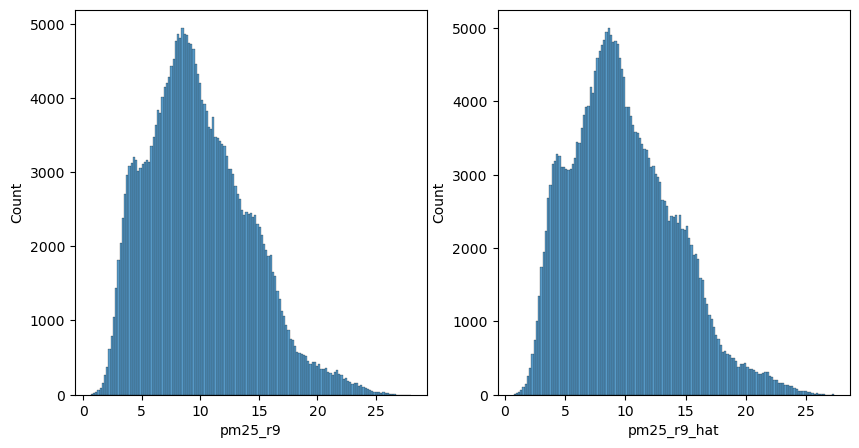

In [19]:
# fit one more model w/ best hyperparams
xgbr_s1_best = xgb.XGBRegressor(**best_params_s1, random_state=20)
xgbr_s1_best.fit(X_s1, y_s1)
y_hat = xgbr_s1_best.predict(X_s1)

# make sure its the same
rmse_val = np.mean(((y_s1 - y_hat)**2)**.5)
print(f"RMSE of the best Stage 1 Model: {rmse_val}")

df_model_s1[target_name_s1+"_hat"] = y_hat # generate predicted pm2.5

columns = [target_name_s1, target_name_s1+'_hat']

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    sns.histplot(
            df_model_s1[columns[idx]],
            ax=ax
        )

# Cross validation function



Making the df_model for Stage 2: `df_model_s2`

In [20]:
# Prepare dataset

print(f"Name of the target variable for Stage 2: {y_var_s2}\n")

predictor_name_s2 = target_name_s1 + "_hat"

print(f"Name of the predictor variable for Stage 2: {predictor_name_s2}\n")

# drop na's in columns of interes, sort by year_month and reset index
df_model_s2 = df_model_s1.dropna(subset=([y_var_s2, predictor_name_s2] + fixed_effects_cols))
df_model_s2 = df_model_s2.sort_values('year_month').reset_index(drop=True)

print(f"Size of 2nd stage df before filtering for modeling: {df_model_s1.shape}")
print(f"Size of 2nd stage df after filtering for modeling: {df_model_s2.shape}")

X_s2 = df_model_s2[[predictor_name_s2] + fixed_effects_cols]
y_s2 = df_model_s2[y_var_s2]

Name of the target variable for Stage 2: y_hematopoietic_fwd3

Name of the predictor variable for Stage 2: pm25_r9_hat

Size of 2nd stage df before filtering for modeling: (262450, 206)
Size of 2nd stage df after filtering for modeling: (66151, 206)


 {'max_depth': 18, 'subsample': 0.8, 'eta': 0.01, 'n_estimators': 100, 'reg_lambda': 1.0}


yields RMSE 2.3061730650578336

In [27]:
# tune XGBoost for Stage 2
output_s2, best_params_s2 = time_series_cv(df_model_s2, 
  xvars = ([predictor_name_s2] + fixed_effects_cols), 
  yvar = y_var_s2, 
  hyperparams = {'max_depth': [18], 
                  'subsample': [.8, 1], 
                  'eta': [0.01, 0.03], 
                  'n_estimators': [180],
                  'reg_lambda': [0.01, 0.1, 1]}, 
  search_type = 'grid', 
  folds = 5, 
  verbose=1)

Working on fold 1/5
Working on fold 2/5
Working on fold 3/5
Working on fold 4/5
Working on fold 5/5
best hyperparams: {'max_depth': 18, 'subsample': 0.8, 'eta': 0.01, 'n_estimators': 100, 'reg_lambda': 1.0}
best RMSE test: 2.3061730650578336


{'max_depth': [18], 
                  'subsample': [.8, 1], 
                  'eta': [0.01, 0.05, .1], 
                  'n_estimators': [180],
                  'reg_lambda': [0.01, 0.1, 1]}

In [28]:
best_params_s2  # best hyperparams for stage 2

{'max_depth': 18,
 'subsample': 0.8,
 'eta': 0.01,
 'n_estimators': 100,
 'reg_lambda': 1.0}

In [29]:
# Visualize CV results
output_s2_df = pd.DataFrame({
  'hyperparams': output_s2['hyperparams'],
  'fold': output_s2['fold'],
  'rmse_train': output_s2['rmse_train'],
  'rmse_test': output_s2['rmse_test'],
  'huber_loss_train': output_s2['huber_loss_train'],
  'huber_loss_test': output_s2['huber_loss_test']
})

output_s2_df['hyperparams'] = output_s2_df['hyperparams'].astype(str)

output_s2_grp = output_s2_df.groupby('hyperparams')[['rmse_train', 'rmse_test', \
'huber_loss_train', 'huber_loss_test']].mean().reset_index().sort_values('rmse_test')

pd.set_option('max_colwidth', None)
output_s2_grp[['hyperparams', 'rmse_test']].head(20)

,hyperparams,rmse_test
38,"{'max_depth': 18, 'subsample': 0.8, 'eta': 0.0...",2.306173
56,"{'max_depth': 18, 'subsample': 1.0, 'eta': 0.0...",2.330186
2,"{'max_depth': 10, 'subsample': 0.8, 'eta': 0.0...",2.353186
20,"{'max_depth': 10, 'subsample': 1.0, 'eta': 0.0...",2.367503
74,"{'max_depth': 3, 'subsample': 0.8, 'eta': 0.01...",2.393911
92,"{'max_depth': 3, 'subsample': 1.0, 'eta': 0.01...",2.404041
110,"{'max_depth': 5, 'subsample': 0.8, 'eta': 0.01...",2.412519
128,"{'max_depth': 5, 'subsample': 1.0, 'eta': 0.01...",2.421670
73,"{'max_depth': 3, 'subsample': 0.8, 'eta': 0.01...",2.430828
72,"{'max_depth': 3, 'subsample': 0.8, 'eta': 0.01...",2.434594


Train final Stage 2 Model with Best Parameters

RMSE of the best Stage 2 Model: 1.3593721571994637


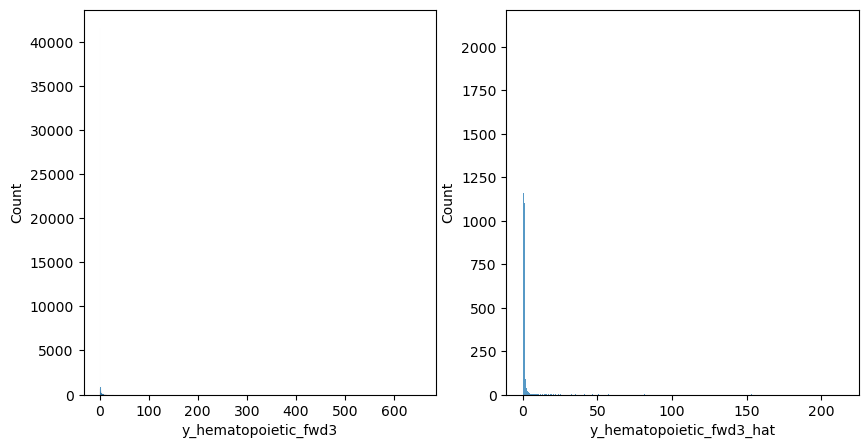

In [42]:
# Train the model using best stage 2's hyper parameters
# fit one more model w/ best hyperparams
xgbr_s2_best = xgb.XGBRegressor(**best_params_s2, random_state=20)
xgbr_s2_best.fit(X_s2, y_s2)
y_s2_hat = xgbr_s2_best.predict(X_s2)

# make sure its the same
rmse_val_s2 = np.mean(((y_s2 - y_s2_hat)**2)**.5)
print(f"RMSE of the best Stage 2 Model: {rmse_val_s2}")

# generate predicted health outcomes
df_model_s2[y_var_s2+"_hat"] = y_s2_hat

columns = [y_var_s2, y_var_s2+"_hat"]

# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    ax.set_xlim(0, 15)
    sns.histplot(
            df_model_s2[columns[idx]],
            ax=ax
        )

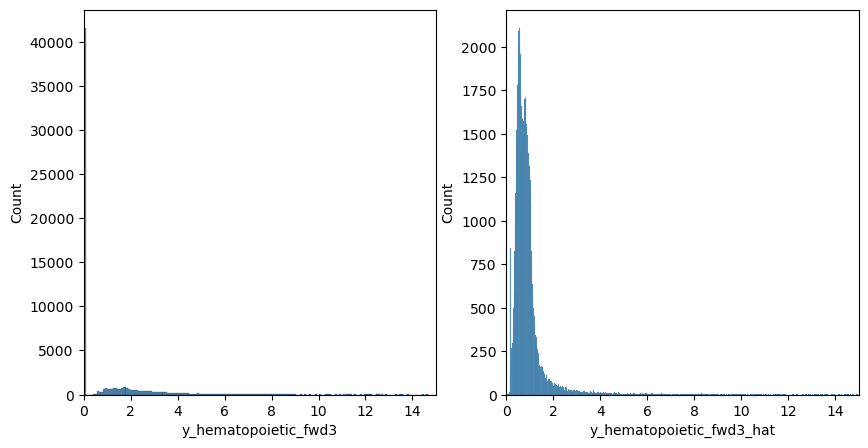

In [44]:
# compute visits by patzip_year_month
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))

for idx, ax in enumerate(axes.flatten()):
    ax.set_xlim(0, 15)
    sns.histplot(
            df_model_s2[columns[idx]],
            ax=ax
        )

In [ ]:
# Evaluate the model

In [ ]:
# Save the predicted Health Outcome to df_model_s2

## Counterfactual Generation: Make the 1%, 10%, 25% mitigation pm25_hat columns

Make these columns, run the s2 XGB on these columns to get their new HO predicted values

Save out csv with columns.

In [ ]:
print(f"Rows originally: {df_model_s2.shape[0]}")
print(f"Rows filtered out: {df_model_s2.shape[0] - df_model_s2[df_model_s2[y_var_s2 + '_hat'] >= 0].shape[0]}")

df_model_s2 = df_model_s2[df_model_s2[y_var_s2 + '_hat'] >= 0]  # filter out the places we predict negative health outcome


In [46]:

# Make Column of 0.99*df_model_s2[predictor_name_s2]
reduced_pm25_col_name = predictor_name_s2 + "_1%_reduction"
df_model_s2[reduced_pm25_col_name] = 0.99 * df_model_s2[predictor_name_s2]
X_temp = df_model_s2[[reduced_pm25_col_name] + fixed_effects_cols]

 # XGBRegressor needs columns to be named the same as during predict, so rename our prediction column for Stage 2
X_temp.rename(columns={reduced_pm25_col_name: predictor_name_s2}, inplace=True)

# Predict Health Outcome for this column, add as column to df_model_s2
df_model_s2[y_var_s2 + "_hat" + "_1%_reduction"] = xgbr_s2_best.predict(X_temp)
df_model_s2["Difference_" + y_var_s2 + "_hat" + "_1%_reduction"] = df_model_s2[y_var_s2 + "_hat" + "_1%_reduction"] - df_model_s2[y_var_s2 + "_hat"]


# Make Column of 0.90*df_model_s2[predictor_name_s2]
reduced_pm25_col_name = predictor_name_s2 + "_10%_reduction"
df_model_s2[reduced_pm25_col_name] = 0.90 * df_model_s2[predictor_name_s2]
X_temp = df_model_s2[[reduced_pm25_col_name] + fixed_effects_cols]
X_temp.rename(columns={reduced_pm25_col_name: predictor_name_s2}, inplace=True)


# Predict Health Outcome for this column, add as column to df_model_s2
df_model_s2[y_var_s2 + "_hat" + "_10%_reduction"] = xgbr_s2_best.predict(X_temp)
df_model_s2["Difference_" + y_var_s2 + "_hat" + "_10%_reduction"] = df_model_s2[y_var_s2 + "_hat" + "_10%_reduction"] - df_model_s2[y_var_s2 + "_hat"]


# Make Column of 0.75*df_model_s2[predictor_name_s2]
reduced_pm25_col_name = predictor_name_s2 + "_25%_reduction"
df_model_s2[reduced_pm25_col_name] = 0.75 * df_model_s2[predictor_name_s2]
X_temp = df_model_s2[[reduced_pm25_col_name] + fixed_effects_cols]
X_temp.rename(columns={reduced_pm25_col_name: predictor_name_s2}, inplace=True)


# Predict Health Outcome for this column, add as column to df_model_s2
df_model_s2[y_var_s2 + "_hat" + "_25%_reduction"] = xgbr_s2_best.predict(X_temp)
df_model_s2["Difference_" + y_var_s2 + "_hat" + "_25%_reduction"] = df_model_s2[y_var_s2 + "_hat" + "_25%_reduction"] - df_model_s2[y_var_s2 + "_hat"]


Adding fixed versions of difference columns to make the counterfactual map legend color bars less weird.

In [ ]:
df_model_s2["Difference_" + y_var_s2 + "_hat" + "_1%_reduction_fixed"] = df_model_s2["Difference_" + y_var_s2 + "_hat" + "_1%_reduction"] \
                                                                    .mask(
                                                                       df_model_s2["Difference_" + y_var_s2 + "_hat" + "_1%_reduction"] > 0, 0 
                                                                    )


df_model_s2["Difference_" + y_var_s2 + "_hat" + "_10%_reduction_fixed"] = df_model_s2["Difference_" + y_var_s2 + "_hat" + "_10%_reduction"] \
                                                                    .mask(
                                                                       df_model_s2["Difference_" + y_var_s2 + "_hat" + "_10%_reduction"] > 0, 0 
                                                                    )

df_model_s2["Difference_" + y_var_s2 + "_hat" + "_25%_reduction_fixed"] = df_model_s2["Difference_" + y_var_s2 + "_hat" + "_25%_reduction"] \
                                                                    .mask(
                                                                       df_model_s2["Difference_" + y_var_s2 + "_hat" + "_25%_reduction"] > 0, 0 
                                                                    )

In [56]:
counter_fact_columns = ['year_month', 'school_zip'] + [i for i in df_model_s2.columns if ('_hat' in i)] 
df_model_s2[counter_fact_columns].head(10)

,year_month,school_zip,pm25_r9_hat,y_hematopoietic_fwd3_hat,pm25_r9_hat_1%_reduction,y_hematopoietic_fwd3_hat_1%_reduction,pm25_r9_hat_10%_reduction,y_hematopoietic_fwd3_hat_10%_reduction,pm25_r9_hat_25%_reduction,y_hematopoietic_fwd3_hat_25%_reduction,pm25_r9_hat_1%_increase,y_hematopoietic_fwd3_hat_1%_increase,pm25_r9_hat_10%_increase,y_hematopoietic_fwd3_hat_10%_increase,pm25_r9_hat_25%_increase,y_hematopoietic_fwd3_hat_25%_increase
0,2002-01-01,95135,13.254518,4.117184,13.121972,4.117184,11.929066,2.115180,9.940888,1.815533,13.387063,4.063320,14.579969,3.979525,16.568148,3.035627
1,2002-01-01,93292,12.638000,0.600512,12.511620,0.600512,11.374199,0.600512,9.478499,0.598385,12.764380,0.600512,13.901800,0.601606,15.797500,0.601606
2,2002-01-01,93256,15.449146,2.287883,15.294655,2.162492,13.904231,1.879049,11.586860,1.624719,15.603638,2.246717,16.994061,2.357871,19.311432,2.590686
3,2002-01-01,93257,15.116611,0.506311,14.965446,0.506311,13.604950,0.523897,11.337459,0.526232,15.267777,0.506311,16.628273,0.512797,18.895763,0.502751
4,2002-01-01,92831,15.240460,1.583712,15.088056,1.556814,13.716414,1.523161,11.430346,1.561073,15.392865,1.583712,16.764507,1.588866,19.050575,1.472946
5,2002-01-01,92841,15.911350,1.176808,15.752237,1.176808,14.320215,1.109094,11.933513,1.057728,16.070463,1.176808,17.502485,1.199552,19.889187,1.195793
6,2002-01-01,92672,15.534554,0.579581,15.379210,0.579581,13.981099,0.599162,11.650916,0.651443,15.689899,0.579581,17.088011,0.579581,19.418194,0.629420
7,2002-01-01,92882,21.898312,0.424272,21.679329,0.424272,19.708481,0.424272,16.423733,0.424272,22.117294,0.424272,24.088142,0.424272,27.372890,0.424272
8,2002-01-01,91977,13.399686,0.384909,13.265689,0.384909,12.059717,0.384909,10.049765,0.385763,13.533683,0.384909,14.739655,0.384909,16.749607,0.384909
9,2002-01-01,91331,12.954837,0.603002,12.825289,0.603002,11.659353,0.561251,9.716127,0.551471,13.084385,0.603002,14.250320,0.589497,16.193546,0.559564


In [57]:
df_model_s2.shape

(66151, 219)

In [94]:
df_model_s2[df_model_s2[y_var_s2 + '_hat'] >= df_model_s2[y_var_s2 + '_hat_1%_reduction']].shape

(59573, 219)

In [95]:
df_model_s2[df_model_s2[y_var_s2 + '_hat'] > df_model_s2[y_var_s2 + '_hat_10%_reduction']].shape

(18315, 219)

In [96]:
df_model_s2[df_model_s2[y_var_s2 + '_hat'] > df_model_s2[y_var_s2 + '_hat_25%_reduction']].shape

(23195, 219)

In [97]:
df_model_s2[df_model_s2[y_var_s2 + '_hat'] > df_model_s2[y_var_s2 + '_hat_25%_reduction']]['school_zip'].value_counts()

93638    107
92841    105
92236    101
95355     98
95354     96
        ... 
93647      2
95954      2
95912      2
93673      2
93272      1
Name: school_zip, Length: 540, dtype: int64

Saving Stage 2: 

In [55]:
df_model_s2.to_csv(os.path.join(out_dir1, counterfactual_csv_name + ".csv"))

Save XGBoost Model

Stage 1

Stage 2